# ToDo

- [x] Dataset download script
- [x] Basic model
- [x] Test/train split
- [x] F1 score analysis
- [x] Document loss in training and plot training loss
  

# GPU


In [ ]:
!nvidia-smi

Wed Apr  6 22:03:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset download

Dataset taken from https://advnet.seas.upenn.edu/

In [ ]:
!gdown --id 13NdhIvPgzOQoRg9A-xUUXSsfxVwPrEUV

Downloading...
From: https://drive.google.com/uc?id=13NdhIvPgzOQoRg9A-xUUXSsfxVwPrEUV
To: /content/LisaCnn.zip
100% 6.47M/6.47M [00:00<00:00, 20.6MB/s]


In [ ]:
!unzip -q LisaCnn.zip 

# Script

In [ ]:
import torch
import glob
import os
import PIL
import torchvision
import numpy as np
from torch.utils.data import random_split

class AdvSignDataset(torch.utils.data.Dataset):
  def __init__(self, path):
    import sklearn.preprocessing
    super().__init__()
    assert path is not None
    self.image_paths = glob.glob(os.path.join(path, "**", "**", "*.jpg"))
    self.data = []

    # self.encoder = sklearn.preprocessing.OneHotEncoder()
    # classes = [p.split("/")[-3] for p in self.image_paths]
    # classes = np.reshape(classes, (-1,1))
    # self.encoder.fit(classes)
    # self.y_sign_types = self.encoder.transform(classes).toarray()
    
    print(f"Found {len(self.image_paths)} images")

  def __getitem__(self, index):
    path = self.image_paths[index]
    isClean = "Clean" in path.split("/")[-2]
    with PIL.Image.open(path) as image:
      return {
          "path": path,
          "type": path.split("/")[-3],
          "isClean": isClean,
          "x": torchvision.transforms.ToTensor()(image),
          "y": torch.tensor([1,0] if isClean else [0,1], dtype=float)
      }
  
  def __len__(self):
    return len(self.image_paths)

In [ ]:
class AdvSignModel(torch.nn.Module):
  def __init__(self) -> None:
    super(AdvSignModel, self).__init__()

    self.layers = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=3, out_channels=512, kernel_size=5, padding="same"),
      torch.nn.Sigmoid(),
      torch.nn.Flatten(),
      torch.nn.BatchNorm1d(num_features=512*32*32),
      torch.nn.Linear(in_features=32*32*512, out_features=2)
    )
  
  def forward(self, x):
    return self.layers(x)

In [ ]:
# Slightly modified implementation of the Lisa CNN model used in cleverhans
# https://github.com/evtimovi/robust_physical_perturbations/blob/master/lisa-cnn-attack/cleverhans/utils_keras.py
class LisaModel(torch.nn.Module):
  def __init__(self) -> None:
    super(LisaModel, self).__init__()

    self.layers = torch.nn.Sequential(
      # 2D Convolutional layer with 64 filters
      torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(8, 8), stride=(2, 2)),
      # ReLU activation layer
      torch.nn.ReLU(),
      # Double the number of filters to extract even more features from the images
      torch.nn.Conv2d(in_channels=64, out_channels=2*64, kernel_size=(6, 6), stride=(2, 2), padding="valid"),
      torch.nn.ReLU(),
      torch.nn.Conv2d(in_channels=2*64, out_channels=2*64, kernel_size=(3, 3), stride=(1, 1), padding="valid"),
      torch.nn.ReLU(),
      # Flatten for the output layer
      torch.nn.Flatten(),
      torch.nn.Linear(in_features=512, out_features=2)
    )
  
  def forward(self, x):
    return self.layers(x)

In [ ]:
class Trainer:
  def __init__(self, model=None, device=None, lr=0.001):
    if model is None: model = AdvSignModel()
    if device is None: device = torch.device("cuda")
    self.device = device
    self.model = model.to(device)
    self.loss_func=torch.nn.CrossEntropyLoss()
    self.model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  
  def train_step(self, x, y):
    y_pred = self.model(x)
    # print(y_pred)
    # https://discuss.pytorch.org/t/categorical-cross-entropy-loss-function-equivalent-in-pytorch/85165/4
    loss = self.loss_func(y_pred, y)
    self.model_optimizer.zero_grad()
    loss.backward()
    self.model_optimizer.step()
    return loss

  def train(
    self,
    epochs=10,
    dataset=None,
    batch_size=256
  ):
    import tqdm.notebook
    if dataset is None: dataset = AdvSignDataset("LisaCnn")
    
    self.dataloader = torch.utils.data.DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=0
    )
    lossHistory = []
    for epoch in tqdm.notebook.tqdm(range(0, epochs), total=epochs):
      for i,v in tqdm.notebook.tqdm(enumerate(self.dataloader), total=len(self.dataloader)):
        x = v["x"].to(self.device)
        y = v["y"].to(self.device)
        # if len(x) != self.dataloader.batch_size: break
        loss = self.train_step(x, y)
        lossHistory.append(loss)
    return lossHistory

In [ ]:
dataset = AdvSignDataset("LisaCnn")
trainData, testData = torch.utils.data.random_split(dataset, [int(0.7*len(dataset)), len(dataset)-int(0.7*len(dataset))])
print(len(dataset), len(trainData), len(testData))

Found 4666 images
4666 3266 1400


In [ ]:
trainer = Trainer(model=LisaModel())
# trainer = Trainer()
loss = trainer.train(dataset=trainData)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
lossCpu = [x.cpu().detach().numpy() for x in loss]

In [ ]:
len(trainData)/256

12.7578125

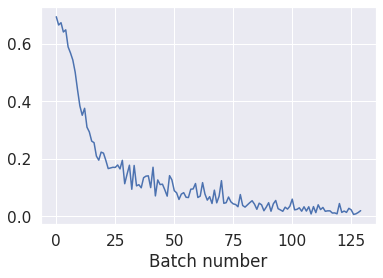

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lossCpu)
plt.xlabel("Batch number")
plt.show()

In [ ]:
pred = []
actual = []
dataloader = torch.utils.data.DataLoader(
  testData,
  batch_size=64,
  shuffle=True,
  num_workers=0
)
import tqdm.notebook
for i,v in tqdm.notebook.tqdm(enumerate(dataloader), total=len(dataloader)):
  x = v["x"].to(trainer.device)
  y_pred=trainer.model(x).cpu().detach().numpy()
  y_pred_flat = y_pred.argmax(1)
  y_flat = v["y"].numpy().argmax(-1)
  pred = np.concatenate([pred, y_pred_flat])
  actual = np.concatenate([actual, y_flat])


  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
import sklearn.metrics
f1 = sklearn.metrics.f1_score(actual, pred)
confusion = sklearn.metrics.confusion_matrix(actual, pred)

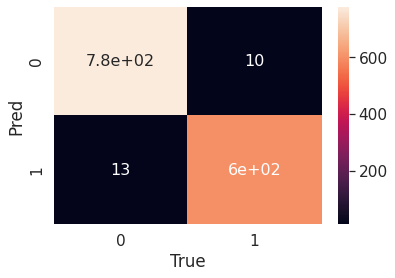

In [ ]:
import seaborn as sn
sn.set(font_scale=1.4)
s = sn.heatmap(confusion, annot=True, annot_kws={"size":16})
s.set(xlabel="True", ylabel="Pred")
plt.show()

In [ ]:
print(f1)

#Some one off experiments - results would need to be averaged to be conclusive
#F1 for 20 epochs 0.9765886287625418
#F1 for 15 epochs 0.9844020797227037, 0.976510067114094
#F1 for 14 epochs 0.983159582999198
#F1 for 12 epochs 0.982995951417004, 0.9810671256454389
#F1 for 11 epochs 0.9849749582637728, 0.9845626072041166, 0.9821428571428571
#F1 for 10 epochs 0.9863013698630138, 0.9724025974025974, 0.9792332268370607, 0.9732793522267206, 0.9748580697485806, 0.9811629811629813
#F1 for 09 epochs 0.9650690495532088
#F1 for 08 epochs 0.9822866344605475

0.9811629811629813


In [ ]:
import time
#Func to test response time
pred = []
dataloader = torch.utils.data.DataLoader(
  testData,
  batch_size=64,
  shuffle=True,
  num_workers=0
)
import tqdm.notebook
tInit = time.time()
for i,v in tqdm.notebook.tqdm(enumerate(dataloader), total=len(dataloader)):
  x = v["x"].to(trainer.device)
  y_pred=trainer.model(x).cpu().detach().numpy()
  y_pred_flat = y_pred.argmax(1)

torch.cuda.current_stream().synchronize()
tFinish = time.time()
#22 * 64 = 1408, so I hard coded the known quanity of test images
tAvg = (tFinish - tInit) / (len(dataloader) * 64) 
tAvgRoudningErr = (tFinish - tInit) / 1400
#print("Average prediction time: " + str(tAvg) + "\nAfter " + str(len(dataloader)*64) + " images")
print("Average prediction time: " + str(tAvg) + "\nAfter 1400 images. Total time: " + str(tFinish - tInit))

  0%|          | 0/22 [00:00<?, ?it/s]

Average prediction time: 0.0004722161049192602
After 1400 images. Total time: 0.6648802757263184


In [ ]:
# Create a trainer instance with the Lisa CNN as a model
lisa_trainer = Trainer(model=LisaModel())
# train the Lisa CNN
lisa_trainer.train(epochs=5, batch_size=16)